Install finished. If prompt appears, Runtime -> Restart runtime and then run the next cells.
Imports OK
Upload your bowling video file (mp4 preferred).


Saving WhatsApp Video 2025-11-04 at 13.08.33_dfb68157.mp4 to WhatsApp Video 2025-11-04 at 13.08.33_dfb68157.mp4
Uploaded: WhatsApp Video 2025-11-04 at 13.08.33_dfb68157.mp4
You will be asked to click two points on a frame to calibrate scale (known real-world distance).


KeyboardInterrupt: 

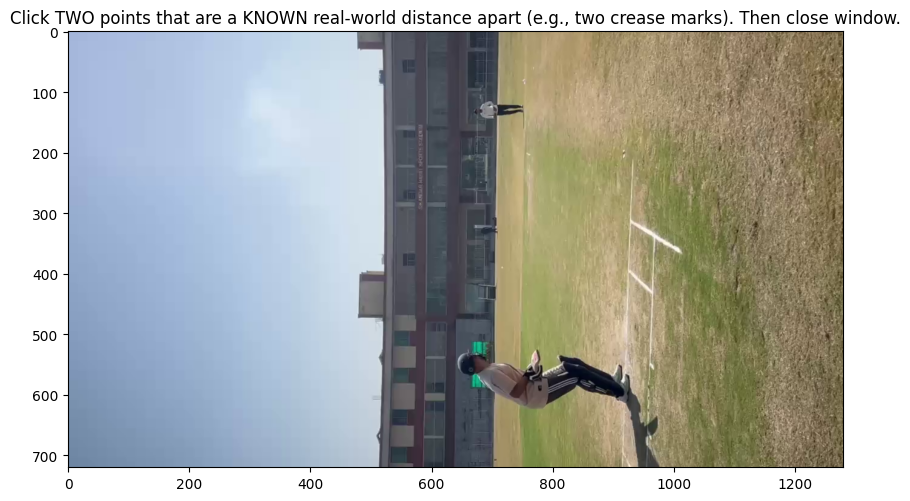

In [4]:
# === Cell 1: Install required packages (run once) ===
!pip install mediapipe==0.10.21 opencv-python==4.11.0.86 numpy==1.26.4 matplotlib==3.10.7 --quiet
print("Install finished. If prompt appears, Runtime -> Restart runtime and then run the next cells.")

# === After restart run the rest of the notebook (all below) ===
# === Cell 2: Imports & helper functions ===
import cv2, os, math
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, HTML, Video
import pandas as pd
print("Imports OK")

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def angle_between(a,b,c):
    a,b,c = np.array(a),np.array(b),np.array(c)
    ba = a-b; bc = c-b
    denom = (np.linalg.norm(ba)*np.linalg.norm(bc))
    if denom==0: return None
    cosang = np.dot(ba,bc)/denom
    cosang = np.clip(cosang,-1,1)
    return np.degrees(np.arccos(cosang))

# Simple tracker: find largest moving small contour each frame after background subtraction
def detect_ball_centroid(frame, bg_subtractor=None, min_area=30, max_area=5000):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    if bg_subtractor:
        fg = bg_subtractor.apply(blur)
        _,th = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)
    else:
        _,th = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # morphological
    kernel = np.ones((3,3),np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = None; best_area=0
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area: continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w/h if h>0 else 0
        # prefer small roughly circular blobs
        if area>best_area:
            best_area=area
            M = cv2.moments(c)
            if M["m00"]!=0:
                cx = int(M["m10"]/M["m00"]); cy = int(M["m01"]/M["m00"])
                best = (cx,cy,area,(x,y,w,h))
    return best

def pixel_dist(p1,p2):
    return math.hypot(p1[0]-p2[0], p1[1]-p2[1])
# === Cell 3: Upload video and set options ===
print("Upload your bowling video file (mp4 preferred).")
uploaded = files.upload()
if len(uploaded)==0:
    raise SystemExit("No file uploaded.")
video_path = list(uploaded.keys())[0]
print("Uploaded:", video_path)

# default bowler side - side view should show bowling arm plane
BOWLER_SIDE = 'RIGHT'  # 'LEFT' if left-arm
# default real world distance we'll ask you to input after you click two points
print("You will be asked to click two points on a frame to calibrate scale (known real-world distance).")
# === Cell 4: Show a sample frame, let user click two calibration points and one stump reference ===
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise SystemExit("Can't read video.")

# display frame for calibration
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Click TWO points that are a KNOWN real-world distance apart (e.g., two crease marks). Then close window.")
coords = plt.ginput(2, timeout=0)  # click two points
plt.close()
if len(coords) < 2:
    raise SystemExit("Calibration points not selected.")

print("Now click the STUMP/target reference point (where batsman stumps are) on the same frame.")
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Click the stump/reference point, then close.")
stump = plt.ginput(1, timeout=0)
plt.close()
if len(stump) < 1:
    raise SystemExit("Stump point not selected.")
cal_pt1 = (int(coords[0][0]), int(coords[0][1]))
cal_pt2 = (int(coords[1][0]), int(coords[1][1]))
stump_pt = (int(stump[0][0]), int(stump[0][1]))

print("Pixels between selected calibration points:", pixel_dist(cal_pt1,cal_pt2))
real_dist_m = float(input("Enter the real-world distance (meters) between the two calibration points you clicked (e.g., 20.12 for full pitch): "))
pixels_per_meter = pixel_dist(cal_pt1,cal_pt2) / real_dist_m
print(f"Calibration done. Pixels per meter: {pixels_per_meter:.2f} px/m")

# === Cell 5: Process video: detect ball, track, find landing, estimate speed and annotate ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_path = 'output_annotated.mp4'
out = cv2.VideoWriter(out_path, fourcc, fps, (w,h))

bg_sub = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=25, detectShadows=False)

frame_idx = 0
ball_positions = []  # (frame_idx, x, y)
detections = []

# We track until ball disappears (after bounce)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    det = detect_ball_centroid(frame, bg_sub, min_area=8, max_area=3000)
    if det:
        cx,cy,area,rect = det
        ball_positions.append((frame_idx, cx, cy))
        cv2.circle(frame, (cx,cy), 6, (0,0,255), -1)
    # draw calibration and stump markers
    cv2.circle(frame, cal_pt1, 6, (0,255,0), -1)
    cv2.circle(frame, cal_pt2, 6, (0,255,0), -1)
    cv2.line(frame, cal_pt1, cal_pt2, (0,255,0), 1)
    cv2.circle(frame, stump_pt, 6, (255,0,0), -1)
    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print("Ball detection pass complete. Frames with detections:", len(ball_positions))

if len(ball_positions) < 3:
    raise SystemExit("Not enough ball detections — try clearer side view video or better contrast.")

# === Cell 6: Analyze trajectory, compute speeds, find landing frame ===
# Convert to numpy arrays
frames_np = np.array([t[0] for t in ball_positions])
xs = np.array([t[1] for t in ball_positions])
ys = np.array([t[2] for t in ball_positions])

# Smooth positions simple moving average to reduce noise
def smooth(arr, k=3):
    if len(arr) < k: return arr
    return np.convolve(arr, np.ones(k)/k, mode='same')

xs_s = smooth(xs, k=5)
ys_s = smooth(ys, k=5)

# Compute per-frame pixel displacements -> m/s
dx = np.diff(xs_s); dy = np.diff(ys_s)
dpx = np.hypot(dx, dy)
# convert to meters using pixels_per_meter
dmeters = dpx / pixels_per_meter
# speed (m/s) = distance / (1/fps) = distance * fps
speeds_m_s = dmeters * fps
speeds_kmh = speeds_m_s * 3.6

# approximate landing: detect frame where vertical speed changes sign (downwards then upwards) OR where y is maximum (lowest on image)
# For side-view with origin top-left, ground => larger y. We'll pick local maximum y before ball disappears.
landing_idx = int(np.argmax(ys_s))
landing_frame, landing_x_px, landing_y_px = ball_positions[landing_idx]
landing_x_m = (landing_x_px - stump_pt[0]) / pixels_per_meter  # lateral in meters relative to stump x
landing_y_m = (h - landing_y_px) / pixels_per_meter  # height from bottom in meters (approx.)
# Distance from stump along pitch axis (x-direction sign indicates in front/behind)
dist_from_stump_m = (stump_pt[0] - landing_x_px) / pixels_per_meter

# speed summary: take median of top segment (first half of trajectory) as release speed estimate
if len(speeds_kmh) > 0:
    release_speed_kmh = np.median(speeds_kmh[: max(1, len(speeds_kmh)//3)])
else:
    release_speed_kmh = 0.0

# classify length heuristics (distance from stump)
# positive dist_from_stump_m means landing in front of stump towards batsman;
# We'll define:
# - yorker: landing within 0.5 m of stump
# - good length: 0.5 - 3.0 m
# - short: > 3.0 m (these thresholds are heuristic)
abs_dist = abs(dist_from_stump_m)
if abs_dist <= 0.5:
    length_label = "Yorker"
elif abs_dist <= 3.0:
    length_label = "Good length"
else:
    length_label = "Short / Back of a length"

# line: lateral offset from stump (we use difference in vertical axis? depending on camera orientation)
lateral_m = (landing_y_px - stump_pt[1]) / pixels_per_meter  # how far to side in meters (sign depends on orientation)
# For simplicity we compute line offset as lateral_m
if abs(lateral_m) < 0.3:
    line_label = "On stump"
elif lateral_m < 0:
    line_label = "Going to off stump side"
else:
    line_label = "Going to leg stump side"

# type by speed heuristic
if release_speed_kmh >= 135:
    type_label = "Fast"
elif release_speed_kmh >= 110:
    type_label = "Medium-Fast"
else:
    type_label = "Spin/Medium"

# bouncer detection: if landing is relatively short (distance large negative) OR large vertical movement early -> simple heuristic:
is_bouncer = abs_dist < 2.0 and landing_y_px < h*0.6  # heuristic: high bounce point
bouncer_label = "Bouncer" if is_bouncer else ""

# Prepare results dataframe
results = {
    "estimated_release_speed_kmh": float(release_speed_kmh),
    "landing_frame": int(landing_frame),
    "landing_x_px": int(landing_x_px),
    "landing_y_px": int(landing_y_px),
    "dist_from_stump_m": float(dist_from_stump_m),
    "length_label": length_label,
    "line_label": line_label,
    "type_label": type_label,
    "bouncer": bool(is_bouncer),
}

df = pd.DataFrame([results])
df.to_csv("analysis.csv", index=False)
print("Analysis summary:")
print(df.T)

# === Cell 7: Create annotated video with textual overlays and show plots ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out2 = cv2.VideoWriter('output_annotated.mp4', fourcc, fps, (w,h))
frame_idx = 0
pos_idx = 0

# produce annotations: write speed, length, line for frames where ball detected
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if pos_idx < len(ball_positions) and frame_idx == ball_positions[pos_idx][0]:
        cx,cy = ball_positions[pos_idx][1], ball_positions[pos_idx][2]
        cv2.circle(frame, (cx,cy), 7, (0,0,255), -1)
        # find nearest speed sample
        if pos_idx < len(speeds_kmh):
            sp = speeds_kmh[max(0, pos_idx-1)]
            cv2.putText(frame, f"Speed~{sp:.1f} km/h", (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
        pos_idx += 1
    # overlay results text top-left
    cv2.putText(frame, f"Est. Release: {results['estimated_release_speed_kmh']:.1f} km/h", (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255),2)
    cv2.putText(frame, f"Length: {results['length_label']}", (10,45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255),2)
    cv2.putText(frame, f"Line: {results['line_label']}", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255),2)
    if results["bouncer"]:
        cv2.putText(frame, "Bouncer detected", (10,95), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,128,255),2)
    # draw stump and calibration
    cv2.circle(frame, cal_pt1, 6, (0,255,0), -1)
    cv2.circle(frame, cal_pt2, 6, (0,255,0), -1)
    cv2.circle(frame, stump_pt, 6, (255,0,0), -1)
    out2.write(frame)
    frame_idx += 1

cap.release()
out2.release()
print("Annotated video saved: output_annotated.mp4")
display(Video("output_annotated.mp4", embed=True, width=720))

# show speed plot over detections if available
if len(speeds_kmh)>0:
    plt.figure(figsize=(10,4))
    plt.plot(speeds_kmh, marker='o')
    plt.title("Estimated speed per detection (km/h)")
    plt.xlabel("Detection index")
    plt.ylabel("Speed (km/h)")
    plt.grid(True)
    plt.show()

print("CSV saved: analysis.csv")
files.download("analysis.csv")
files.download("output_annotated.mp4")